# Step 3 — Data Processing

The workflow is:

1. Read dataset
2. Process & normalize datetime column
3. Determine data types
4. Split into train/validation/test (time-ordered)
5. Handle missing values (fit only on training set)
6. Handle outliers (IQR-based clipping, fit only on training set)
7. Build transformers and ColumnTransformer + Pipeline
8. Compute and visualize correlation matrix
9. Normalize numeric data



## 1) Read data

Load the CSV file and show a small preview (first 5 rows) and list of columns.


In [8]:
import pandas as pd

csv_path = r"C:/Users/lenovo/Downloads/python exercises/ml/machine_learning_lab/dataset/merged_hn.csv"
df = pd.read_csv(csv_path)
print('Shape:', df.shape)
df.head()

# Show columns
print('\nColumns:')
for c in df.columns:
    print('-', c)


Shape: (3926, 33)

Columns:
- name
- datetime
- tempmax
- tempmin
- temp
- feelslikemax
- feelslikemin
- feelslike
- dew
- humidity
- precip
- precipprob
- precipcover
- preciptype
- snow
- snowdepth
- windgust
- windspeed
- winddir
- sealevelpressure
- cloudcover
- visibility
- solarradiation
- solarenergy
- uvindex
- severerisk
- sunrise
- sunset
- moonphase
- conditions
- description
- icon
- stations


## 2) Process & normalize datetime column
We automatically detect a datetime-like column (common names: 'date', 'datetime', 'time', 'timestamp').
We parse it into `pd.Timestamp` dtype and extract useful features (year, month, day, dayofweek, hour).
We keep the new numeric columns for modeling and drop the original datetime column to avoid leakage.


In [9]:

# Auto-detect datetime column
def detect_datetime_column(df):
    candidates = [c for c in df.columns if any(k in c.lower() for k in ('date','time','datetime','timestamp'))]
    # if none, also check object columns to see if they parse as dates for first non-null entry
    if not candidates:
        for c in df.select_dtypes(include=['object','string']).columns:
            try:
                pd.to_datetime(df[c].dropna().iloc[0])
                candidates.append(c)
                break
            except Exception:
                continue
    return candidates[0] if candidates else None

dt_col = detect_datetime_column(df)
print('Detected datetime column:', dt_col)

if dt_col is None:
    print('No datetime detected. You may need to specify the datetime column name manually.')
else:
    df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
    # create features
    df['dt_year'] = df[dt_col].dt.year
    df['dt_month'] = df[dt_col].dt.month
    df['dt_day'] = df[dt_col].dt.day
    df['dt_dayofweek'] = df[dt_col].dt.dayofweek
    print(df[[dt_col,'dt_year','dt_month','dt_day','dt_dayofweek']].head())
df.head()

Detected datetime column: datetime
    datetime  dt_year  dt_month  dt_day  dt_dayofweek
0 2015-01-01     2015         1       1             3
1 2015-01-02     2015         1       2             4
2 2015-01-03     2015         1       3             5
3 2015-01-04     2015         1       4             6
4 2015-01-05     2015         1       5             0


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunset,moonphase,conditions,description,icon,stations,dt_year,dt_month,dt_day,dt_dayofweek
0,Hanoi,2015-01-01,24.0,11.4,17.7,24.0,11.4,17.7,9.4,63.8,...,2015-01-01T17:26:18,0.36,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999...",2015,1,1,3
1,Hanoi,2015-01-02,22.0,11.0,16.3,22.0,11.0,16.3,9.4,65.6,...,2015-01-02T17:26:56,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999...",2015,1,2,4
2,Hanoi,2015-01-03,21.0,13.1,17.0,21.0,13.1,17.0,12.4,75.6,...,2015-01-03T17:27:34,0.43,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999...",2015,1,3,5
3,Hanoi,2015-01-04,22.6,16.9,19.3,22.6,16.9,19.3,16.1,82.0,...,2015-01-04T17:28:12,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999...",2015,1,4,6
4,Hanoi,2015-01-05,23.0,18.5,20.4,23.0,18.5,20.4,18.4,88.4,...,2015-01-05T17:28:51,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"48820099999,48823099999,48825099999,4883109999...",2015,1,5,0


## 3) Determine data types

We split columns into numeric and categorical candidates. Numeric columns will be processed with imputation, outlier handling and scaling. Categorical columns will be imputed and one-hot encoded (without scaling).

In [10]:

# Automatic type detection
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
# Keep the newly created datetime-derived numeric features if exist
numeric_cols = [c for c in numeric_cols if not str(c).lower().startswith('unnamed')]

categorical_cols = df.select_dtypes(include=['object','category','string']).columns.tolist()

# remove detected datetime column from categorical list if present
if dt_col and dt_col in categorical_cols:
    categorical_cols.remove(dt_col)

print('Numeric columns (examples):', numeric_cols)
print('Categorical columns (examples):', categorical_cols)


Numeric columns (examples): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase', 'dt_year', 'dt_month', 'dt_day', 'dt_dayofweek']
Categorical columns (examples): ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


## 4) Split data into train/validation/test (time-ordered)

Because this dataset is temporal (weather), we split by time order to avoid lookahead leakage. We use 70% train, 15% validation, 15% test. If no datetime column is found we'll do a random split.


In [11]:

from math import floor

df_proc = df.copy()

if dt_col is not None and dt_col in df_proc.columns:
    df_proc = df_proc.sort_values(by=dt_col).reset_index(drop=True)
    n = len(df_proc)
    n_train = int(n * 0.70)
    n_val = int(n * 0.15)
    train = df_proc.iloc[:n_train].reset_index(drop=True)
    val = df_proc.iloc[n_train:n_train + n_val].reset_index(drop=True)
    test = df_proc.iloc[n_train + n_val:].reset_index(drop=True)
else:
    # fallback random split
    from sklearn.model_selection import train_test_split
    train, temp = train_test_split(df_proc, test_size=0.30, random_state=42)
    val, test = train_test_split(temp, test_size=0.50, random_state=42)

print('Train shape:', train.shape)
print('Validation shape:', val.shape)
print('Test shape:', test.shape)


Train shape: (2748, 37)
Validation shape: (588, 37)
Test shape: (590, 37)


## 5) Handle missing values + outliers + scaling using sklearn Pipelines

We create transformers that are fit **only** on the training set. For numeric features we use:

- `SimpleImputer(strategy='median')` for missing values
- `OutlierClipper` (custom): fit calculates IQR bounds per numeric column on training data and clips values during transform
- `StandardScaler()` to normalize numeric features

For categorical features we use `SimpleImputer(strategy='constant', fill_value='missing')` + `OneHotEncoder(handle_unknown='ignore')`.
All parts are combined with `ColumnTransformer` and wrapped in a final `Pipeline`.


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Custom transformer: OutlierClipper (IQR-based clipping) ---
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
        self.lower_ = None
        self.upper_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        q1 = np.nanpercentile(X, 25, axis=0)
        q3 = np.nanpercentile(X, 75, axis=0)
        iqr = q3 - q1
        self.lower_ = q1 - self.multiplier * iqr
        self.upper_ = q3 + self.multiplier * iqr
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_clipped = np.minimum(np.maximum(X, self.lower_), self.upper_)
        return X_clipped
    def get_feature_names_out(self, input_features=None):
        return input_features

# --- Create pipeline pieces ---
numeric_features = [c for c in numeric_cols if c not in ('dt_year', 'dt_month', 'dt_day', 'dt_dayofweek', 'dt_hour')]

# include datetime-derived numeric features as numeric too
datetime_derived = [c for c in df.columns if c.startswith('dt_')]
for c in datetime_derived:
    if c not in numeric_features:
        numeric_features.append(c)

cat_features = categorical_cols.copy()

print('Final numeric features used in pipeline (examples):', numeric_features[:15])
print('Final categorical features used in pipeline (examples):', cat_features[:15])

# --- Define numeric pipeline ---
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierClipper(multiplier=1.5)),
    ('scaler', StandardScaler())
])

# --- Define categorical pipeline (OrdinalEncoder instead of OneHotEncoder) ---
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# --- Combine both pipelines ---
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, cat_features)
], remainder='drop')

# --- Full pipeline ---
full_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# --- Fit only on training set ---
X_train = train.drop(columns=[dt_col]) if dt_col in train.columns else train.copy()
X_val = val.drop(columns=[dt_col]) if dt_col in val.columns else val.copy()
X_test = test.drop(columns=[dt_col]) if dt_col in test.columns else test.copy()

print('Fitting pipeline on training set...')
full_pipeline.fit(X_train)

print('Transforming train/val/test...')
X_train_trans = full_pipeline.transform(X_train)
X_val_trans = full_pipeline.transform(X_val)
X_test_trans = full_pipeline.transform(X_test)

print('Transformed shapes:', X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)


Final numeric features used in pipeline (examples): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed']
Final categorical features used in pipeline (examples): ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']
Fitting pipeline on training set...
Transforming train/val/test...
Transformed shapes: (2748, 35) (588, 35) (590, 35)


c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with 

## 6) Compute and visualize correlation matrix

We compute the correlation matrix on the numeric features after imputation and outlier clipping but **before** scaling (so correlations reflect original relationships). For visualization we use matplotlib to present a heatmap.


c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['severerisk']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


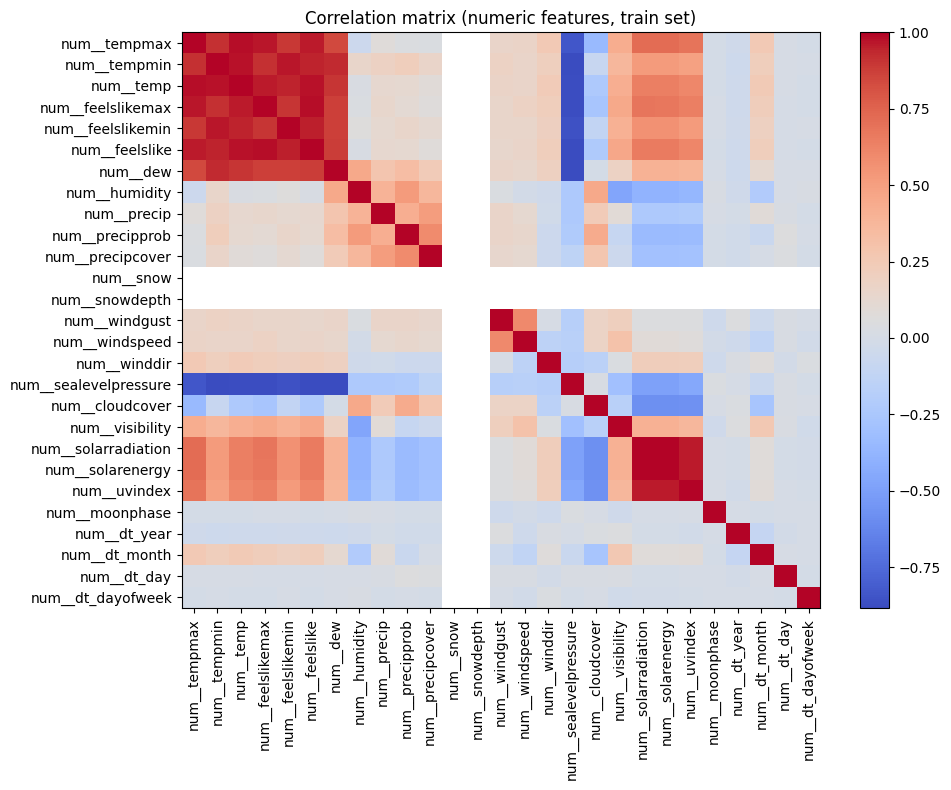

,num__tempmax,num__tempmin,num__temp,num__feelslikemax,num__feelslikemin,num__feelslike,num__dew,num__humidity,num__precip,num__precipprob
num__tempmax,1.000000,0.914210,0.978947,0.966457,0.894775,0.957399,0.845286,-0.055984,0.079071,0.041957
num__tempmin,0.914210,1.000000,0.971180,0.913831,0.963207,0.945202,0.931245,0.150337,0.188136,0.217234
num__temp,0.978947,0.971180,1.000000,0.959646,0.944958,0.976154,0.901291,0.026882,0.127741,0.119068
num__feelslikemax,0.966457,0.913831,0.959646,1.000000,0.902369,0.979014,0.868969,0.030520,0.145914,0.107931
num__feelslikemin,0.894775,0.963207,0.944958,0.902369,1.000000,0.954314,0.868703,0.062346,0.122814,0.148372
num__feelslike,0.957399,0.945202,0.976154,0.979014,0.954314,1.000000,0.876760,0.014901,0.127577,0.119848
num__dew,0.845286,0.931245,0.901291,0.868969,0.868703,0.876760,1.000000,0.452722,0.282355,0.337094
num__humidity,-0.055984,0.150337,0.026882,0.030520,0.062346,0.014901,0.452722,1.000000,0.393170,0.519907
num__precip,0.079071,0.188136,0.127741,0.145914,0.122814,0.127577,0.282355,0.393170,1.000000,0.419100
num__precipprob,0.041957,0.217234,0.119068,0.107931,0.148372,0.119848,0.337094,0.519907,0.419100,1.000000


In [13]:
# Rebuild numeric-only pipeline (without scaling)
from sklearn.pipeline import Pipeline

numeric_pipeline_noscale = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierClipper(multiplier=1.5)),
])

num_only_preproc = ColumnTransformer([
    ('num', numeric_pipeline_noscale, numeric_features)
], remainder='drop')

# Fit and transform training numeric data
num_only_preproc.fit(X_train)
X_train_num = num_only_preproc.transform(X_train)

# Safely get feature names
try:
    col_names_num = num_only_preproc.get_feature_names_out()
except Exception:
    col_names_num = numeric_features[:X_train_num.shape[1]]

# Create DataFrame for correlation
import pandas as pd
X_train_num_df = pd.DataFrame(X_train_num, columns=col_names_num)

# Compute correlation matrix
corr = X_train_num_df.corr()

# Plot heatmap using matplotlib (no seaborn)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation matrix (numeric features, train set)')
plt.tight_layout()
plt.show()

# Display a preview of correlation matrix
corr.iloc[:10, :10]

## 7) Save processed datasets and brief notes

We save transformed arrays (numpy) as `.npy` files for later modeling. You can modify the target column and adapt the pipeline further.


In [14]:
# Save preprocessed data
import os
os.makedirs("data_step3", exist_ok=True)
try:
    col_names = full_pipeline.get_feature_names_out()
except Exception:
    # Nếu sklearn cũ chưa có hàm này
    col_names = [f"feature_{i}" for i in range(X_train_trans.shape[1])]

# (Tuỳ chọn) Làm gọn tên cột nếu cần
col_names = [name.replace('num__', '').replace('cat__', '') for name in col_names]

# === TẠO DATAFRAME VÀ LƯU CSV ===
os.makedirs("data_step3", exist_ok=True)

X_train_df = pd.DataFrame(X_train_trans, columns=col_names)
X_val_df = pd.DataFrame(X_val_trans, columns=col_names)
X_test_df = pd.DataFrame(X_test_trans, columns=col_names)

X_train_df.to_csv("data_step3/x_train_trans.csv", index=False)
X_val_df.to_csv("data_step3/x_val_trans.csv", index=False)
X_test_df.to_csv("data_step3/x_test_trans.csv", index=False)

train.to_csv("data_step3/train.csv", index=False)
val.to_csv("data_step3/valid.csv", index=False)
test.to_csv("data_step3/test.csv", index=False)
